# Cleaning and "Spine" Creation

In [1]:
import pandas as pd
import numpy as np

# 1. Load the data
df = pd.read_csv('archive/PJME_hourly.csv')
df.head

<bound method NDFrame.head of                    Datetime  PJME_MW
0       2002-12-31 01:00:00  26498.0
1       2002-12-31 02:00:00  25147.0
2       2002-12-31 03:00:00  24574.0
3       2002-12-31 04:00:00  24393.0
4       2002-12-31 05:00:00  24860.0
...                     ...      ...
145361  2018-01-01 20:00:00  44284.0
145362  2018-01-01 21:00:00  43751.0
145363  2018-01-01 22:00:00  42402.0
145364  2018-01-01 23:00:00  40164.0
145365  2018-01-02 00:00:00  38608.0

[145366 rows x 2 columns]>

In [2]:

# 2. Convert to datetime and sort
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

# 3. Handle Duplicates (Common in DST 'Fall Back')
# We take the mean of the energy load if a timestamp appears twice
df = df.groupby('Datetime').mean().reset_index()

# 4. Create a "Full Range" Spine
# This identifies if any hours are missing from the sequence
full_range = pd.date_range(start=df['Datetime'].min(), 
                           end=df['Datetime'].max(), 
                           freq='h')
spine = pd.DataFrame({'Datetime': full_range})

# 5. Merge Spine with Data
# Any missing hours will now show up as NaN in the 'PJME_MW' column
df = pd.merge(spine, df, on='Datetime', how='left')

# 6. Fill Gaps (Intermediate Skill: Interpolation)
# If 1 hour is missing, we shouldn't just put 0; we interpolate between neighbors
print(f"Missing hours found: {df['PJME_MW'].isna().sum()}")
df['PJME_MW'] = df['PJME_MW'].interpolate(method='linear')

# 7. Basic Time Features (Internal Features)
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year

print("Spine created successfully. Shape:", df.shape)

Missing hours found: 30
Spine created successfully. Shape: (145392, 6)


# Fetching Weather Data (Meteostat)

In [3]:
from meteostat import Point, Hourly
from datetime import datetime

# Define Philadelphia coordinates
philly = Point(39.9526, -75.1652)

# Set time period (matching your PJME dataset range)
start = df['Datetime'].min()
end = df['Datetime'].max()

# Get hourly data
data = Hourly(philly, start, end)
weather_df = data.fetch()

In [4]:
# Reset index so 'time' becomes a column and convert to timezone-naive to match PJME
weather_df = weather_df.reset_index()
weather_df['time'] = weather_df['time'].dt.tz_localize(None)

# Select key features: Temperature (temp) and Humidity (rhum)
weather_df = weather_df[['time', 'temp', 'dwpt', 'rhum']]
weather_df.columns = ['Datetime', 'temp', 'dewpoint', 'humidity']

In [5]:
# Merge with your energy dataframe
df = pd.merge(df, weather_df, on='Datetime', how='left')

# Check for weather gaps and fill
df[['temp', 'humidity']] = df[['temp', 'humidity']].interpolate()

print(df.head())
df.to_csv('PJME_Clean_with_Weather.csv', index=False)
print(df.columns)


             Datetime  PJME_MW  hour  dayofweek  month  year  temp  dewpoint  \
0 2002-01-01 01:00:00  30393.0     1          1      1  2002  -2.2     -14.0   
1 2002-01-01 02:00:00  29265.0     2          1      1  2002  -2.8     -13.3   
2 2002-01-01 03:00:00  28357.0     3          1      1  2002  -3.3     -13.3   
3 2002-01-01 04:00:00  27899.0     4          1      1  2002  -3.9     -13.3   
4 2002-01-01 05:00:00  28057.0     5          1      1  2002  -5.0     -13.3   

   humidity  
0      40.0  
1      44.0  
2      46.0  
3      48.0  
4      52.0  
Index(['Datetime', 'PJME_MW', 'hour', 'dayofweek', 'month', 'year', 'temp',
       'dewpoint', 'humidity'],
      dtype='object')


# Feature Engineering Code

In [6]:
# 1. Cyclical Encoding for Hour
# 24 hours in a day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# 2. Cyclical Encoding for Month 
# 12 months in a year
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 3. Lag Features (The model looks back)
# Create a 24-hour lag (yesterday's energy) and a 7-day lag
df['energy_lag_24h'] = df['PJME_MW'].shift(24)
df['energy_lag_7d'] = df['PJME_MW'].shift(168)

# 4. Rolling Window Features
# 24-hour rolling average temperature (captures thermal inertia)
print(df.columns)
df['temp_roll_avg_24h'] = df['temp'].rolling(window=24).mean()

Index(['Datetime', 'PJME_MW', 'hour', 'dayofweek', 'month', 'year', 'temp',
       'dewpoint', 'humidity', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'energy_lag_24h', 'energy_lag_7d'],
      dtype='object')


In [7]:
# 5. Drop NaNs created by lagging/rolling
# (You'll lose the first 7 days of data because they have no previous week to look at)
df = df.dropna()

print("Feature engineering complete. New columns:", df.columns.tolist())

Feature engineering complete. New columns: ['Datetime', 'PJME_MW', 'hour', 'dayofweek', 'month', 'year', 'temp', 'dewpoint', 'humidity', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'energy_lag_24h', 'energy_lag_7d', 'temp_roll_avg_24h']


# Time Series Split

In [8]:
from sklearn.model_selection import TimeSeriesSplit

# 1. Sort by date one last time to be safe
df = df.sort_values('Datetime')

# 2. Define Features (X) and Target (y)
# We drop 'Datetime' because the model can't process raw timestamps
features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
            'temp', 'humidity', 'energy_lag_24h', 'energy_lag_7d', 
            'temp_roll_avg_24h', 'dayofweek']
target = 'PJME_MW'

X = df[features]
y = df[target]

# 3. Setup TimeSeriesSplit (5-fold)
# This splits your data into 5 consecutive "folds"
tss = TimeSeriesSplit(n_splits=5, test_size=24*30*3) # 3 months per test fold

In [9]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(f"Train period: {df.iloc[train_index]['Datetime'].min()} to {df.iloc[train_index]['Datetime'].max()}")
    print(f"Test period:  {df.iloc[test_index]['Datetime'].min()} to {df.iloc[test_index]['Datetime'].max()}")
    print("-" * 30)

Train period: 2002-01-08 01:00:00 to 2017-05-10 00:00:00
Test period:  2017-05-10 01:00:00 to 2017-08-08 00:00:00
------------------------------
Train period: 2002-01-08 01:00:00 to 2017-08-08 00:00:00
Test period:  2017-08-08 01:00:00 to 2017-11-06 00:00:00
------------------------------
Train period: 2002-01-08 01:00:00 to 2017-11-06 00:00:00
Test period:  2017-11-06 01:00:00 to 2018-02-04 00:00:00
------------------------------
Train period: 2002-01-08 01:00:00 to 2018-02-04 00:00:00
Test period:  2018-02-04 01:00:00 to 2018-05-05 00:00:00
------------------------------
Train period: 2002-01-08 01:00:00 to 2018-05-05 00:00:00
Test period:  2018-05-05 01:00:00 to 2018-08-03 00:00:00
------------------------------


# Training with XGBoost

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# 1. Initialize lists to store scores for each fold
mape_scores = []

# 2. Iterate through the TimeSeriesSplit folds
for train_index, test_index in tss.split(X):
    # Split data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 3. Define and Fit the Model
    # we use early_stopping_rounds to prevent overfitting
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        objective='reg:squarederror'
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # 4. Predict and Evaluate
    preds = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, preds)
    mape_scores.append(mape)
    
    print(f"Fold MAPE: {mape:.4f}")

print(f"Average Cross-Validated MAPE: {np.mean(mape_scores):.4f}")

Fold MAPE: 0.0377
Fold MAPE: 0.0350
Fold MAPE: 0.0301
Fold MAPE: 0.0321
Fold MAPE: 0.0403
Average Cross-Validated MAPE: 0.0351


# Visualizing Feature Importance

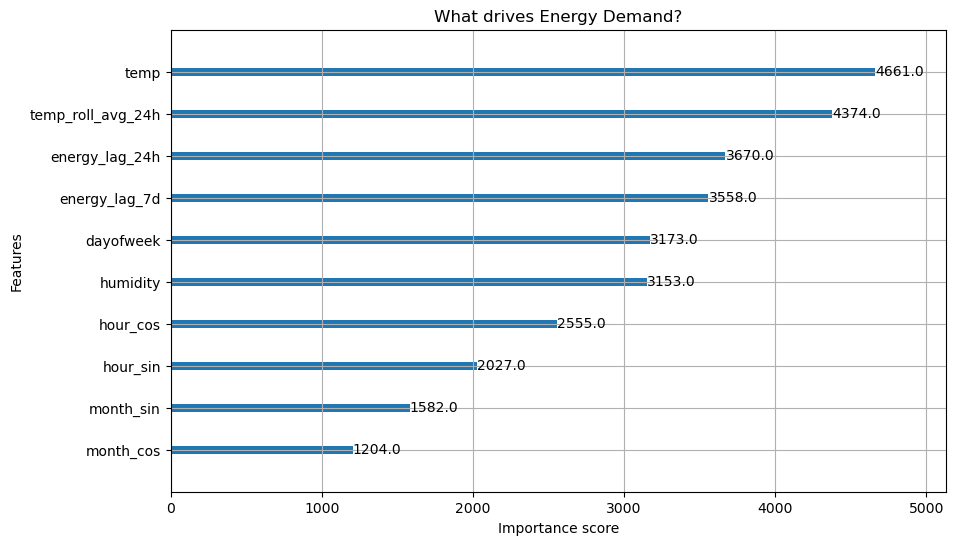

In [11]:
import matplotlib.pyplot as plt

# Plot Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, ax=plt.gca(), importance_type='weight')
plt.title("What drives Energy Demand?")
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Calculate metrics
mape = mean_absolute_percentage_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"--- Performance Scorecard ---")
print(f"Average Error: {mae:.2f} MW")
print(f"Accuracy (MAPE): {100 - (mape * 100):.2f}%")

--- Performance Scorecard ---
Average Error: 1349.63 MW
Accuracy (MAPE): 95.97%


In [13]:
# 1. Create the Naive Baseline (24-hour persistence)
# We use the test set and assume the prediction is just the 24-hour lag
y_naive = X_test['energy_lag_24h']

# 2. Calculate MAPE for both
mape_baseline = mean_absolute_percentage_error(y_test, y_naive)
mape_model = mean_absolute_percentage_error(y_test, preds)

# 3. Calculate Improvement
improvement = (mape_baseline - mape_model) / mape_baseline * 100

print(f"Baseline (Naive) MAPE: {mape_baseline:.4f}")
print(f"XGBoost Model MAPE:    {mape_model:.4f}")
print(f"Overall Improvement:   {improvement:.2f}%")

Baseline (Naive) MAPE: 0.0909
XGBoost Model MAPE:    0.0403
Overall Improvement:   55.60%


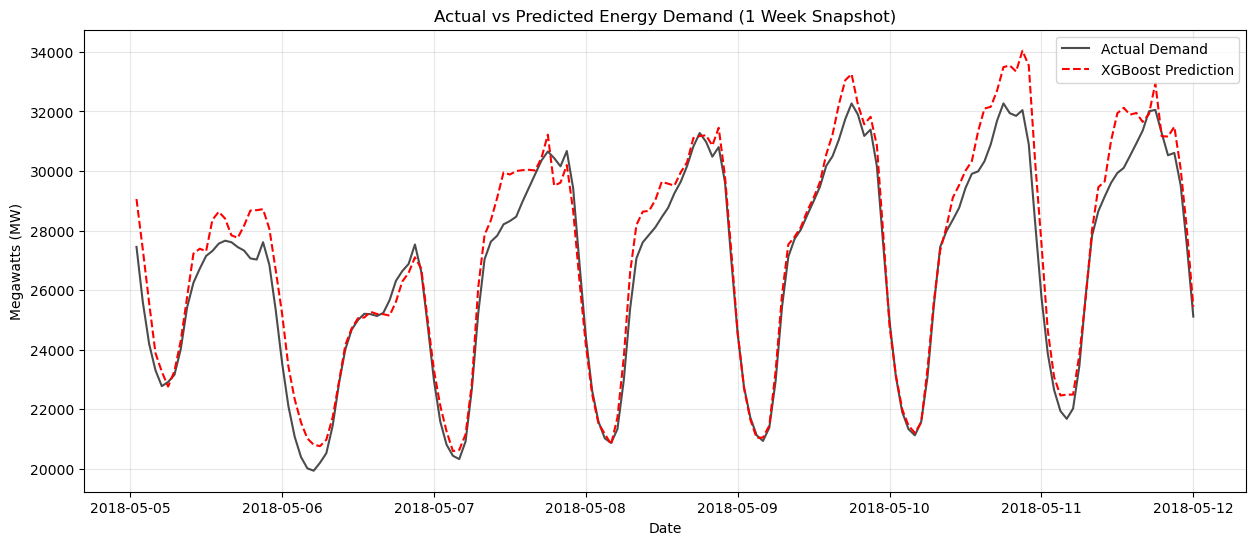

In [14]:
import matplotlib.pyplot as plt

# Create a summary dataframe for the test period
results = pd.DataFrame({
    'Actual': y_test,
    'Prediction': preds
}, index=X_test.index)

# Plotting the first 7 days of the test set
plt.figure(figsize=(15, 6))
plt.plot(df.loc[results.index[:168], 'Datetime'], results['Actual'][:168], label='Actual Demand', color='black', alpha=0.7)
plt.plot(df.loc[results.index[:168], 'Datetime'], results['Prediction'][:168], label='XGBoost Prediction', color='red', linestyle='--')

plt.title("Actual vs Predicted Energy Demand (1 Week Snapshot)")
plt.xlabel("Date")
plt.ylabel("Megawatts (MW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Residual Plotting

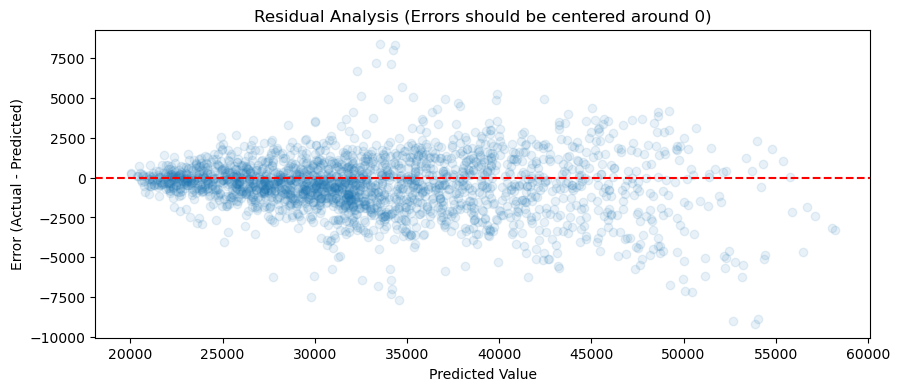

In [15]:
results['Residuals'] = results['Actual'] - results['Prediction']

plt.figure(figsize=(10, 4))
plt.scatter(results['Prediction'], results['Residuals'], alpha=0.1)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Analysis (Errors should be centered around 0)")
plt.xlabel("Predicted Value")
plt.ylabel("Error (Actual - Predicted)")
plt.show()